In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import brainpy.math as bm
from Network_Multiple_Maps_wyl import Place_net, Grid_net
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import os
import random

# Set the path
path = '/home/yulingwu/CCS_place_grid/Storing_multiple_maps/final_remapping/figure_0715/hyper'
if not os.path.exists(path):
  os.makedirs(path)
os.chdir(path)

# Set the random seed
seed = 3
np.random.seed(seed)
bm.random.seed(seed)
random.seed(seed)

In [2]:
z_min = 0
z_max = 20
place_num = 800
grid_num = 20
module_num = 10
map_num = 25
a_p = 0.5
Spacing = np.linspace(6,20,module_num)

Place_cell = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=place_num, place_num=place_num, noise_stre=0.5)
maps = bm.as_numpy(Place_cell.map) 
place_index = bm.as_numpy(Place_cell.place_index) 


Gird_module_list = bm.NodeList([])
for module in range(module_num):
    Grid_cell = Grid_net(L = Spacing[module], maps=maps, place_index=place_index, neuron_num=grid_num, J0=5, a_g=a_p/Spacing[module]*2*bm.pi, W0=0.05)
    Gird_module_list.append(Grid_cell)

conn_out = Grid_cell.conn_out
map_index = 0

In [ ]:
data = np.load('/home/yulingwu/CCS_place_gridStoring_multiple_maps/final_remapping/data/sorted_u_place_control.npz')
sorted_u_place_couple = data['sorted_u_place_control']
data = np.load('/home/yulingwu/CCS_place_griddd/Storing_multiple_maps/final_remapping/data/sorted_u_place_inactivated.npz')
sorted_u_place = data['sorted_u_place_inactivated']
z = bm.linspace(0, 20, sorted_u_place.shape[0])

In [4]:
from scipy.ndimage import gaussian_filter

sorted_u_place_couple = gaussian_filter(sorted_u_place_couple, sigma=2)
sorted_u_place = gaussian_filter(sorted_u_place, sigma=2)

In [5]:
# plt.rcParams.update({'font.size': 13, 'font.family': 'Arial'})
# fig, ax = plt.subplots(place_num // 10, 10, figsize=(10 * 4, (place_num // 10) * 4))
# ax = ax.flatten()

# for i in range(place_num):
#     ax[i].plot(z, sorted_u_place_couple[:, i] * 1000, color='b', label='Control')
#     ax[i].plot(z, sorted_u_place[:, i] * 1000, color='r', label='MEC depolarized')
#     ax[i].set_xlabel('Spatial location in Map 1')  # Optional: Add X axis label
#     ax[i].set_ylabel('Firing rate (Hz)')
#     ax[i].legend(loc='best')  # Add legend to each subplot with optimal location
#     ax[i].set_title(f'Neuron #{i}')

# plt.tight_layout()
# plt.show()

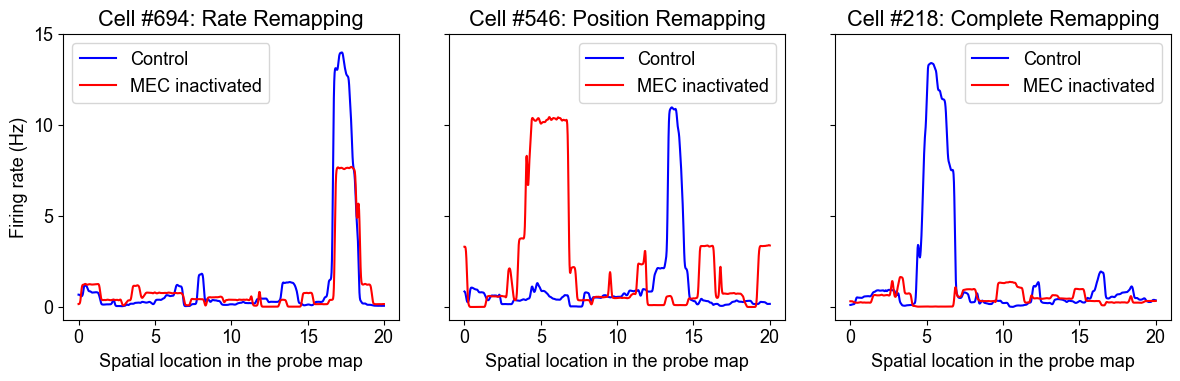

In [6]:
from matplotlib.ticker import MaxNLocator

neuron_index = np.array([694, 546, 218])

plt.rcParams.update({'font.size': 13, 'font.family': 'Arial'})
fig, ax = plt.subplots(1, 3, figsize=(3*4, 4), sharey=True)
for i in range(3):
    ax[i].plot(z, sorted_u_place_couple[:, neuron_index[i]] * 1000, color='b', label='Control')
    ax[i].plot(z, sorted_u_place[:, neuron_index[i]] * 1000, color='r', label='MEC inactivated')
    ax[i].set_xlabel('Spatial location in the probe map')
    ax[i].legend(loc='best')
    ax[i].set_yticks([0, 5, 10, 15])

ax[0].set_ylabel('Firing rate (Hz)')
ax[0].set_title('Cell #694: Rate Remapping')
ax[1].set_title('Cell #546: Position Remapping')
ax[2].set_title('Cell #218: Complete Remapping')
plt.tight_layout(w_pad=2.5)
plt.savefig('a.pdf', dpi=300, bbox_inches='tight')


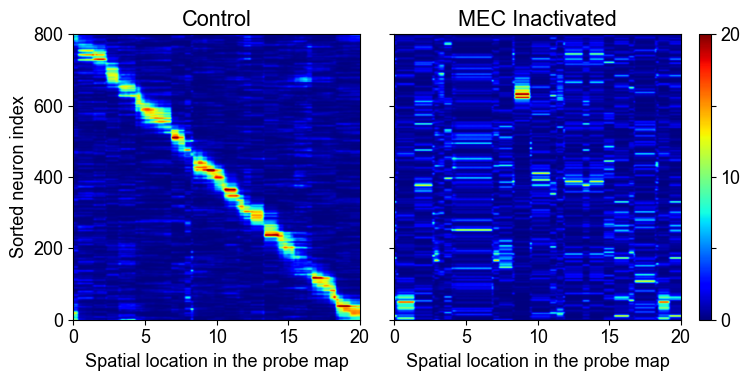

In [7]:
# imshow
flipped_sorted_u_place_couple = np.flipud(sorted_u_place_couple.T)
flipped_sorted_u_place = np.flipud(sorted_u_place.T)

vmax = 20
fig, ax = plt.subplots(1, 2, figsize=(7.5, 4), sharey=True)

# Plot the first imshow
im0 = ax[0].imshow(np.flipud(1000*flipped_sorted_u_place_couple), aspect='auto', cmap='jet', vmax=vmax,
                   extent=[z[0], z[-1], 0, place_num])
ax[0].set_xlabel('Spatial location in the probe map')
ax[0].set_ylabel('Sorted neuron index')
ax[0].set_title('Control')
ax[0].set_yticks([0, 200, 400, 600, 800])
ax[0].set_yticklabels(['0', '200', '400', '600', '800'])

# Plot the second imshow
im1 = ax[1].imshow(np.flipud(1000*flipped_sorted_u_place), aspect='auto', cmap='jet', vmax=vmax,
                   extent=[z[0], z[-1], 0, place_num])
ax[1].set_xlabel('Spatial location in the probe map')
ax[1].set_title('MEC Inactivated')
ax[1].set_yticks([0, 200, 400, 600, 800])
ax[1].set_yticklabels(['0', '200', '400', '600', '800'])

plt.tight_layout(rect=[0, 0, 0.96, 1])

pos = ax[1].get_position()
cbar_ax = fig.add_axes([0.945, pos.y0, 0.015, pos.height])
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.set_ticks([0, 5, 10, 15, 20])
cbar.set_ticklabels(['0', '', '10', '', '20'])

plt.savefig('d.pdf', dpi=300, bbox_inches='tight')
plt.show()


692


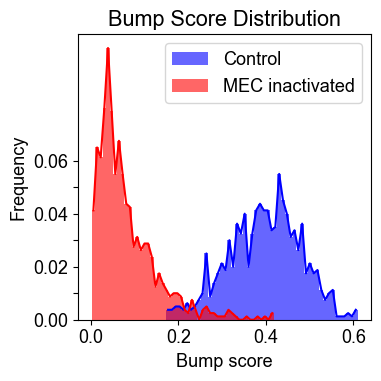

In [ ]:
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 13, 'font.family': 'Arial'})
# Define distance function
def dist(a, b, L):
  dis = np.abs(a - b)
  dis = np.where(dis < L / 2, dis, L - dis)
  return dis

# Calculate bump score
def bump_score(sorted_u_place):
  # loc_space = np.linspace(0, 20, timestep)
  place_cell_feature = np.linspace(0, 20, place_num)
  scores = np.zeros(place_num)
  for loc_j in range(place_num):
    loc_neuron = place_cell_feature[loc_j]
    dis = dist(loc_neuron, z, 20)
    bump = np.exp(-dis**2 / (2 * a_p**2))
    u_place = sorted_u_place[:, loc_j]
    u_place = u_place / np.sum(u_place)
    scores[loc_j] = np.sum(bump * u_place)
  return scores

# Calculate scores
scores_only = bump_score(sorted_u_place)
scores_couple = bump_score(sorted_u_place_couple)
print(np.argmax(scores_only))

# Calculate histogram for scores_couple
counts_couple, bins_couple = np.histogram(scores_couple, bins=50)
counts_couple = counts_couple / np.sum(counts_couple)  # Normalize to frequency
bin_centers_couple = (bins_couple[:-1] + bins_couple[1:]) / 2

# Calculate histogram for scores_only
counts_only, bins_only = np.histogram(scores_only, bins=50)
counts_only = counts_only / np.sum(counts_only)  # Normalize to frequency
bin_centers_only = (bins_only[:-1] + bins_only[1:]) / 2

# Plot histogram and envelope
plt.figure(figsize=(4,4))
plt.bar(bin_centers_couple, counts_couple, width=bin_centers_couple[1] - bin_centers_couple[0], alpha=0.6, color='b', label='Control')
plt.plot(bin_centers_couple, counts_couple, color='b')

plt.bar(bin_centers_only, counts_only, width=bin_centers_only[1] - bin_centers_only[0], alpha=0.6, color='r', label='MEC inactivated')
plt.plot(bin_centers_only, counts_only, color='r')

# Add labels and title
plt.xlabel('Bump score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Bump Score Distribution')
plt.yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06], ['0.00', '', '0.02', '', '0.04', '', '0.06'])
# plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2e}'))

plt.tight_layout()
plt.savefig('e.pdf', dpi=300)
plt.show()
